In [24]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv(r"C:\Users\Chisom Ejim\Documents\2024\Machine Learning\Datasets\Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [26]:
features = ['Annual Income (k$)','Spending Score (1-100)']

In [27]:
# use dropna method to drops rows where one of the columns in features have null or missen value (clustering can't work with missen values)
df = df.dropna(subset = features)

In [28]:
# copy selected features into new data frame
dff = df[features].copy()

In [29]:
dff

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [30]:
# scale data (min-max scaling) - preserves the variance in the data
#dff = ((dff - dff.min()) / (dff.max() - dff.min())) * 9 + 1

In [31]:
dff

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [32]:
dff.describe()

,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000
mean,60.560000,50.200000
std,26.264721,25.823522
min,15.000000,1.000000
25%,41.500000,34.750000
50%,61.500000,50.000000
75%,78.000000,73.000000
max,137.000000,99.000000


In [33]:
dff.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


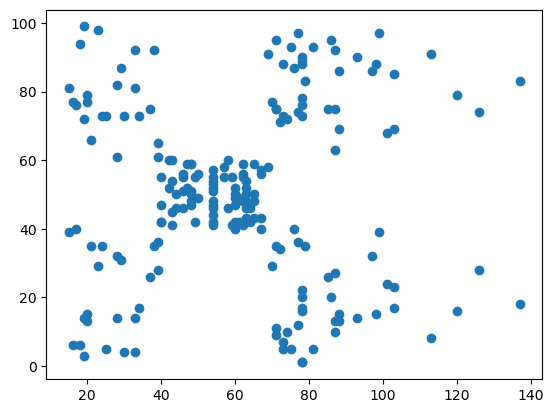

In [34]:
import matplotlib.pyplot as plt
plt.scatter(data = dff, x = 'Annual Income (k$)', y = 'Spending Score (1-100)' );

Visually, we can make out 5 fairly discernable clusters and having k = 5 happens to work really well for our customer segmentation.

In [35]:
# initialize random centroids
def random_centroids(dff, k):
    np.random.seed(2) 
    centroids = []
    for i in range(k):
        centroid = dff.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis = 1)

np.random.seed(2) ensures the random number generator produces the same centroids for every iteration.

N/B: This was only used after multiple iterations where favorable randomly initialized centroids were obtained. 

In [36]:
centroids = random_centroids(dff, 5)

In [37]:
centroids

,0,1,2,3,4
Annual Income (k$),64.0,120.0,78.0,64.0,88.0
Spending Score (1-100),82.0,74.0,48.0,79.0,17.0


In [38]:
# Euclidean distance - calculating distance between each data points and the cluster centroids
distances = centroids.apply(lambda x: np.sqrt((( dff - x) ** 2).sum(axis = 1)))

def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt((( dff - x) ** 2).sum(axis = 1)))   # Euclidean distance
    return distances.idxmin(axis = 1)                                                  # Cluster assignment per customer

In [39]:
labels = get_labels(dff, centroids)

In [40]:
# get no of customers in each cluster
labels.value_counts()

2    84
3    43
4    39
0    24
1    10
Name: count, dtype: int64

In [41]:
# get geometric mean
def new_centroids(dff, labels,k):
    return dff.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T  

Despite this being a 2D dataset, we'll import the PCA library to rotate the data to align with the principal components.

In [42]:
from sklearn.decomposition import PCA             
from matplotlib.lines import Line2D
from IPython.display import clear_output                  # To clear the previous graph each time we plot new graph

In [43]:
def plot_clusters(dff, labels, centroids, iteration):
    pca = PCA(n_components = 2)
    dff_2d = pca.fit_transform(dff)
    centroids_2d = pca.transform(centroids.T)                
    clear_output(wait = True)  
    plt.figure(figsize=(10,8))
    plt.title(f'iteration { iteration} ')
    plt.scatter(x = dff_2d[:,0], y = dff_2d[:,1], c = labels)
    plt.scatter(x = centroids_2d[:,0], y = centroids_2d[:,1], marker = 'X', s = 100, c = 'r')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    proxy_artists = [Line2D([0], [0], marker = 'o', color = 'w', label = 'Cluster 0', markerfacecolor = 'purple'),
                     Line2D([0], [0], marker = 'o', color = 'w', label = 'Cluster 1', markerfacecolor = 'navy'),
                     Line2D([0], [0], marker = 'o', color = 'w', label = 'Cluster 2', markerfacecolor = 'skyblue'),
                     Line2D([0], [0], marker = 'o', color = 'w', label = 'Cluster 3', markerfacecolor = 'lightgreen'),
                     Line2D([0], [0], marker = 'o', color = 'w', label = 'Cluster 4', markerfacecolor = 'yellow')]
    plt.legend(handles = proxy_artists,loc = 'upper right')
    plt.show()

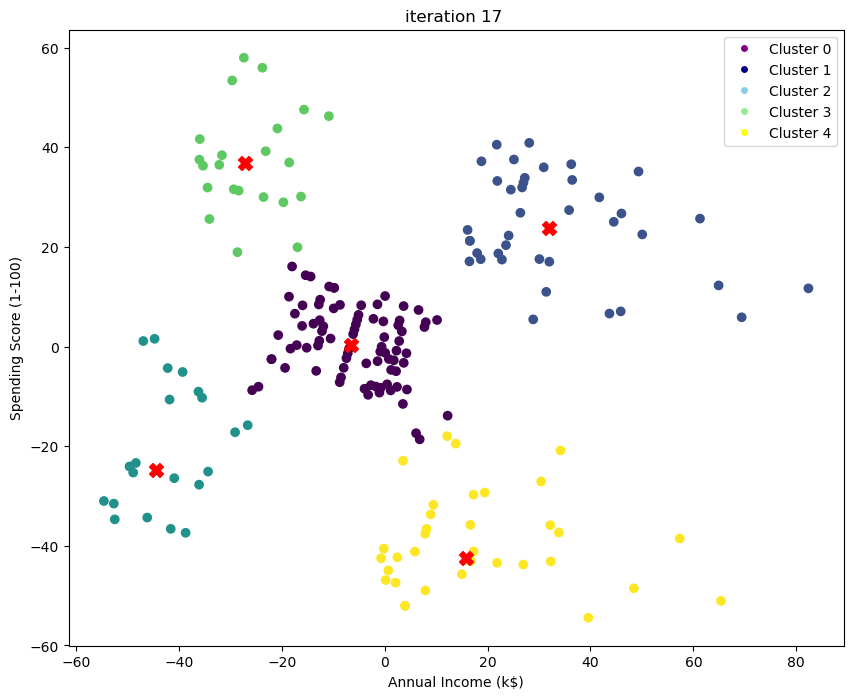

In [44]:
max_iterations = 100
k = 5

centroids = random_centroids(dff, k)
old_centroids = pd.DataFrame()
iteration =  1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    labels = get_labels(dff, centroids)
    centroids = new_centroids(dff, labels, k)
    plot_clusters(dff, labels, centroids, iteration)
    iteration +=1

In [45]:
centroids

,0,1,2,3,4
Annual Income (k$),54.097937,85.221266,24.171052,24.673277,86.885283
Spending Score (1-100),48.700137,81.599249,14.674264,78.710859,13.365447


In [46]:
df[labels == 3]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
1,2,Male,21,15,81
3,4,Female,23,16,77
5,6,Female,22,17,76
7,8,Female,23,18,94
9,10,Female,30,19,72
11,12,Female,35,19,99
13,14,Female,24,20,77
15,16,Male,22,20,79
17,18,Male,20,21,66
19,20,Female,35,23,98
